# ASISTENTE INTELIGENTE PARA CONSULTAS DE TRANSITO

## Guía de pasos realizados para la creación del asistente

1. Importamos las librerias necesarias

In [54]:
from typing import Literal

from langchain import hub
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from langchain_core.prompts import PromptTemplate
from typing_extensions import Annotated, List, TypedDict
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from IPython.display import Image, display
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()
#

base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  # Adjust this path based on your actual directory structure

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"



Cargamos el modelo de deepseek

In [55]:
openai_api_key = os.getenv("OPENAI_API_KEY")
# openai_base_url = os.getenv("DEEPSEEK_API_URL")
# openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    model_name= "gpt-4o-mini",
    temperature=0.5, 
    api_key=openai_api_key,
    # base_url=openai_base_url,
)   

Cargar un documento

In [56]:
def split_doc(file_path: str) -> List[Document] :
    
    # Gets directory where the current script is
    loader = TextLoader(file_path , encoding='utf-8')
    leyes = loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    docs = text_splitter.split_documents(leyes)
    
    return docs

Definir base de datos

In [57]:
def crear_vector_db() -> InMemoryVectorStore:
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")  
    vector_store = InMemoryVectorStore(embeddings)

    return vector_store

Cargar documentos de transito a la base de datos

In [58]:
def add_doc_to_vector_db(vector_store: InMemoryVectorStore, docs: List[Document]):
    vector_store.add_documents(docs)
    
def load_all_laws(vector_store: InMemoryVectorStore, leyes_dir: str):
    # Load all laws from the directory
    for file in os.listdir(leyes_dir):
        file_path = os.path.join(leyes_dir, file)
        if os.path.isfile(file_path) and file.endswith('.txt'):
            docs = split_doc(file_path)
            add_doc_to_vector_db(vector_store, docs)

Defino el prompt a enviar a la ia y la estructura de prompt

In [91]:
# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Cons/ulta de busqueda sobre leyes de transito boliviano para ejecutar, no es necesario nombrar bolivia."]
    
    
template = """ Responde exclusivamente en español. 
Eres un asistente legal que puede responder preguntas sobre el 
reglamento de tránsito boliviano.
Usa solamente información de la referencia para responder. 
En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
En tu respuesta referencia el articulo que corresponda a tu respuesta.

Usa la siguiente información como referencia: {context}

Responde a la siguiente pregunta: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

llamamos a las funciones para preparar la base de datos

In [60]:
vector_store = crear_vector_db()
load_all_laws(vector_store, leyes_dir)

Definir los estados de langgraph


In [ ]:
class State(TypedDict):
    question: str
    context: List[Document]
    query: Search
    answer: str
    system_message: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### Creando el Grafo de Estados

In [97]:
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

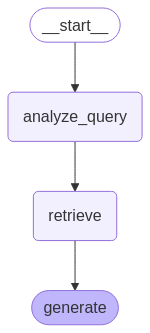

In [98]:
display(Image(graph.get_graph().draw_mermaid_png()))

Invocar al grafo

In [99]:
result = graph.invoke({
    "question": "cuales es la velocidad maxima en carretera?",
    "system_message": "Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano en bolivia, no menciones a bolivia en el query."
})
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='9ef44c2f-54fb-47fb-8101-41784cf69d00', metadata={'source': 'e:\\Code\\Python\\Asistente-Legal-API\\App\\leyes\\1978-BO-RE-RS187444(1).txt'}, page_content='Capítulo VII\nDel procedimiento ante el juzgado del tránsito'), Document(id='3b913ff3-ae01-4361-afeb-d96373cb5f77', metadata={'source': 'e:\\Code\\Python\\Asistente-Legal-API\\App\\leyes\\reglamento_codigo_de_transito.txt'}, page_content='Capítulo VII\nDel procedimiento ante el juzgado del tránsito'), Document(id='5d761b1e-0971-497b-aacd-16f6ed44f9f9', metadata={'source': 'e:\\Code\\Python\\Asistente-Legal-API\\App\\leyes\\1978-BO-RE-RS187444(1).txt'}, page_content="atenderá en la vía conciliatoria, con facultad para imponer sanciones, las\ndemandas y reclamaciones de carácter civil a las que se refieren los artículos\n175 y 176 del Código_de_Tránsito, a no ser que las partes hubieran señalado\nvoluntariamente cláusulas penales (multas) sometiéndose expresamente a la\njurisdicción y competencia de Tránsito caso